## Plotting lab

For this plotting lab, we ask you to load the weather data for Edmonton, Calgary, Victoria and Saskatoon. Ensure you have found the set of dates where you have weather data for all four cities.

In [1]:
## Let's import our code from Lecture 8 (Simple Stats) and Lab 8.
## we'll modify it a little bit so it can grab the weather data from
## multiple directories.

import datetime as dt
import os as os
from operator import itemgetter
import collections as co
import fnmatch as fn    ## library for finding files using OS wildcards
import numpy as np

print("Python current working directory:", os.getcwd())

## directories containing the weather w.* subdirectories
sdp = ['./L8.data', '../data']

## Build the list of directories of the weather files.
wsubdirs = sum( [[x+'/'+y for y in fn.filter(os.listdir(x), "w.*")] for x in sdp], [] )

print("Relative location of weather .csv files: ", wsubdirs)

Python current working directory: /home/user/repos/mp248-planning/Labs
Relative location of weather .csv files:  ['./L8.data/w.cal', './L8.data/w.edm', '../data/w.sask', '../data/w.vic']


In [2]:
## basic line formatting. This is used in the next code block.
## Code removes quotes and newlines, and splits along commas.
def fmtline(ln):
    PL = ln.translate({ord(c): None for c in '"\n'})
    PL = PL.split(",")
    return(PL)

In [3]:
## we will store the file data in a co.defaultdict(dict)
## format initDat["location"][date][dict key such as max temp, min temp, etc.] 

initDat = co.defaultdict(dict)

for wd in wsubdirs:
    files = fn.filter(os.listdir(wd), "eng-daily*.csv")
    for wdf in files:
        with open(wd+'/'+wdf, encoding='utf-8') as f:
            content = f.readlines()
            
            ## find line describing columns
            keylines = [i for i in range(len(content)) if 'date/time' in\
                        content[i].lower()]
            if len(keylines)!=1:
                print("Error: "+wd+'/'+wdf+" key error. ")
                () = () + 1
            
            ## find station data
            stnlines = [i for i in range(len(content)) if 'station name' in\
                        content[i].lower()]
            if len(stnlines)!=1:
                print("Error: "+wd+'/'+wdf+" stn name error. ")
                () = () + 1
                
            airpt = fmtline(content[stnlines[0]])[1]
            keys = fmtline(content[keylines[0]])
            ## get date/time index
            dti = [j for j in range(len(keys)) if 'date/time' in\
                   keys[j].lower()]
            if len(dti)!=1:
                print("Error: "+wd+'/'+wdf+' date/time idx. ')
                () = () + 1
            
            ## let's collect the data
            for i in range(keylines[0]+1, len(content)):
                ln = fmtline(content[i])
                ## convert date/time to python datetime object
                ln[dti[0]] = dt.datetime.strptime(ln[dti[0]], "%Y-%m-%d")
                
                initDat[airpt][ln[dti[0]]] = dict( [ (keys[j] , ln[j]) for j in\
                                                    range(len(keys)) if j != dti[0] ] ) 

In [4]:
## date gap check for initDat, i.e. report what (if any) days have missing weather data.
for A in initDat.keys():
    print("Airport: ", A, ' ', end='')
    sd = sorted( initDat[A].keys() )
    print('First date: ',sd[0].date(), 'Final date: ', sd[-1].date())
    ID = sd[0]
    mD = []
    while ID<sd[-1]:
        ID += dt.timedelta(days=1)
        if ID not in initDat[A].keys():
            mD.append(ID)
    if (len(mD)>0):
        print("Missing dates: ", mD)
    else:
        print(sd[-1].date()-sd[0].date())
        
## list of keys we will have use for.
ncl = ['Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)']

## let's make sure all the max, min, mean, total rain, total snow, total precip floats are present
for A in initDat.keys():
    for k in ncl:
        am = 0
        for d in initDat[A].keys():
            if len(initDat[A][d][k])==0:
                am += 1
        print('Airport: ', A, 'missing ', k, ' count ', am)

Airport:  CALGARY INTL A  First date:  2014-01-01 Final date:  2018-12-31
1825 days, 0:00:00
Airport:  EDMONTON INTL A  First date:  2014-01-01 Final date:  2018-12-31
1825 days, 0:00:00
Airport:  SASKATOON DIEFENBAKER INT'L A  First date:  1970-01-01 Final date:  2012-12-31
15705 days, 0:00:00
Airport:  SASKATOON RCS  First date:  2013-01-01 Final date:  2017-12-31
1825 days, 0:00:00
Airport:  SASKATOON INTL A  First date:  2018-01-01 Final date:  2018-12-31
364 days, 0:00:00
Airport:  VICTORIA INT'L A  First date:  1970-01-01 Final date:  2012-12-31
15705 days, 0:00:00
Airport:  VICTORIA INTL A  First date:  2013-01-01 Final date:  2018-12-31
2190 days, 0:00:00
Airport:  CALGARY INTL A missing  Max Temp (°C)  count  6
Airport:  CALGARY INTL A missing  Min Temp (°C)  count  25
Airport:  CALGARY INTL A missing  Mean Temp (°C)  count  29
Airport:  CALGARY INTL A missing  Total Rain (mm)  count  53
Airport:  CALGARY INTL A missing  Total Snow (cm)  count  17
Airport:  CALGARY INTL A miss

In [5]:
## merge dictionaries for the four cities

edmdict = dict()
caldict = dict()
vicdict = dict()
sasdict = dict()
for k in initDat.keys():
    if 'EDM' in k:
        edmdict.update(initDat[k])
    if 'CAL' in k:
        caldict.update(initDat[k])
    if 'VIC' in k:
        vicdict.update(initDat[k])
    if 'SASK' in k:
        sasdict.update(initDat[k])
        
dictL = [edmdict, caldict, vicdict, sasdict]
dictN = ["Edmonton", "Calgary", "Victoria", "Saskatoon"]

## Let's find a list of common dates where we have weather data for all cities. 
dtlists = [set(k for k,d in D.items() if len(d[ncl[0]])!=0 and len(d[ncl[1]])!=0 and len(d[ncl[2]])!=0) for D in dictL]

## intersection of all the sets
comdt = set.intersection(*dtlists)
## sort the dates.
coml = sorted(comdt)


In [6]:
## for all the cities, and all the common dates, 
## we convert all the measured termperature and precipitation
## items to floats. Here we add the (not too bad) assumption that if precipitation
## is not listed, it should be zero.

for D in dictL:
    for x in coml:
        for k in range(len(ncl)):
            if len(D[x][ncl[k]])==0:
                D[x][ncl[k]]=0.0
            else:
                D[x][ncl[k]]=float(D[x][ncl[k]])
                

**Exercise 1:**  For each year between 2014 and 2018 (i.e. where we have data for all the four cities), make a pie chart.  The slices of the pie fractions (or sizes) will be the percentage of days (for that year) where that city has the highest maximum temperature.  Ensure each slice is labelled by the city name.

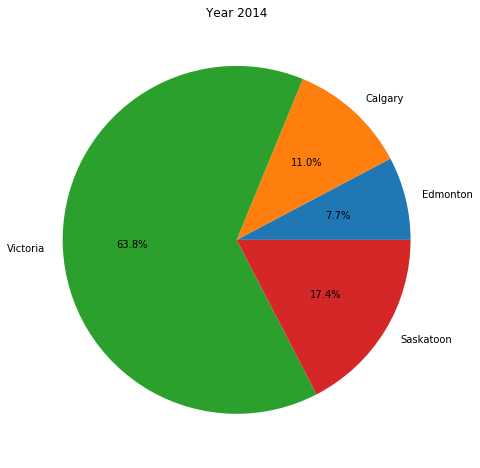

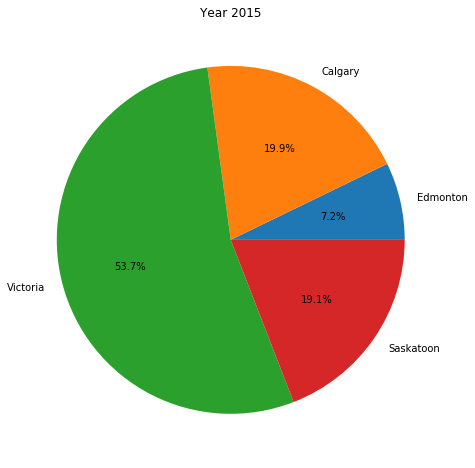

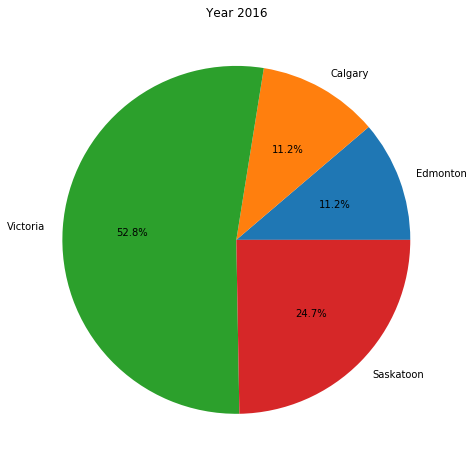

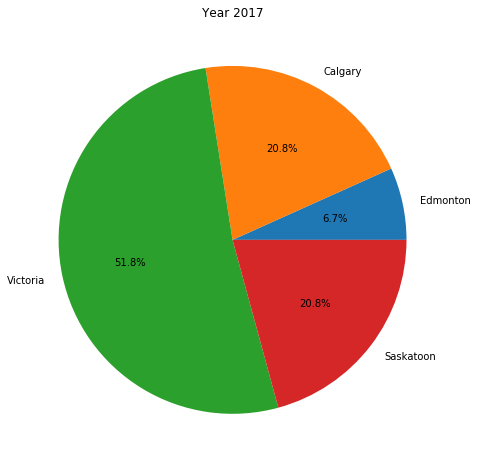

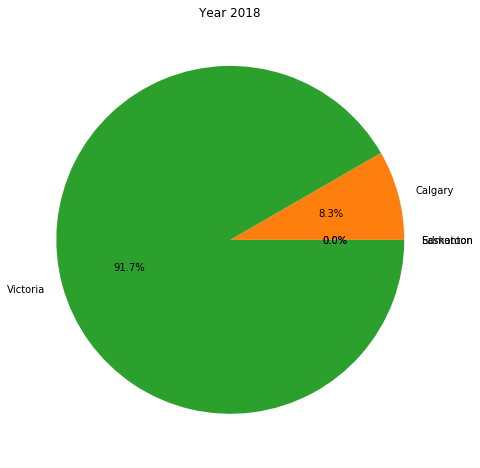

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

## let's store the "daily victory count" as a dictionary that maps pairs (year, city name) to counts.
viclist = co.defaultdict(int)
for x in coml:
    temps = [(dictL[i][x][ncl[0]], dictN[i]) for i in range(4)]
    temps = sorted(temps)
    viclist[(x.year, temps[-1][1])] += 1

yearlist = sorted(set([k[0] for k,v in viclist.items()]))

yeartots = co.defaultdict(int)
for k,v in viclist.items():
    yeartots[k[0]] += v

pcts = co.defaultdict(float)
for y in yearlist:
    for c in dictN:
        pcts[(y,c)] = 100.0*viclist[(y,c)]/yeartots[y]

for y in yearlist:
    pc = [pcts[(y,c)] for c in dictN]
    plt.figure(figsize=(8,8))
    plt.title("Year "+str(y))
    plt.pie(pc, labels=dictN, autopct='%1.1f%%')
    plt.show()

**Exercise 2:** Repeat Exercise 1, but use only summer weather.

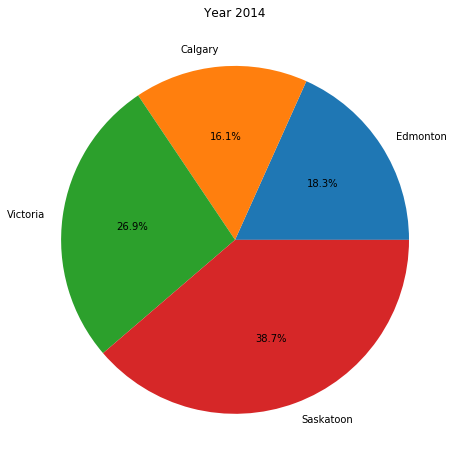

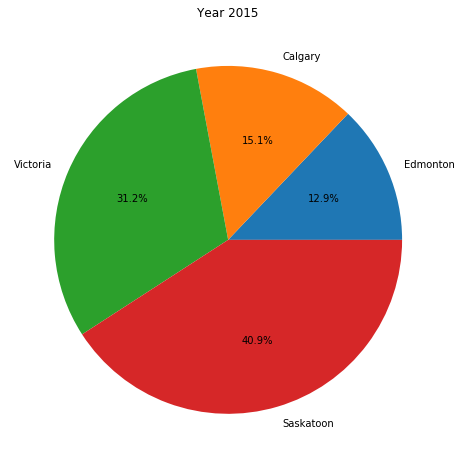

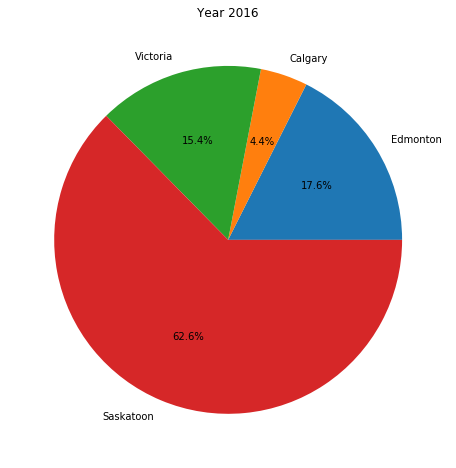

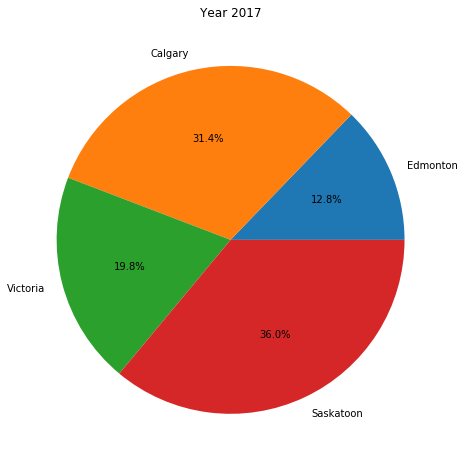

In [8]:
## We will use June 21st as the first day of summer -- the actual date depends on the year, but
## given that we are making pie charts, being one day inaccurate is of no real consequence.
## Similarly, we use September 23rd for fall's start.

## let's store the "daily victory count" as a dictionary that maps pairs (year, city name) to counts.
viclist = co.defaultdict(int)
for x in coml:
    summer_dt = dt.datetime(x.year, 5, 21)
    fall_dt = dt.datetime(x.year, 8, 23)
    if x>=summer_dt and x<fall_dt:
        temps = [(dictL[i][x][ncl[0]], dictN[i]) for i in range(4)]
        temps = sorted(temps)
        viclist[(x.year, temps[-1][1])] += 1

yearlist = sorted(set([k[0] for k,v in viclist.items()]))

yeartots = co.defaultdict(int)
for k,v in viclist.items():
    yeartots[k[0]] += v

pcts = co.defaultdict(float)
for y in yearlist:
    for c in dictN:
        pcts[(y,c)] = 100.0*viclist[(y,c)]/yeartots[y]

for y in yearlist:
    pc = [pcts[(y,c)] for c in dictN]
    plt.figure(figsize=(8,8))
    plt.title("Year "+str(y))
    plt.pie(pc, labels=dictN, autopct='%1.1f%%')
    plt.show()

**Exercise 3:** Repeat Exercise 1, but use the number of days that city has the lowest maximum temperature (among the four cities).

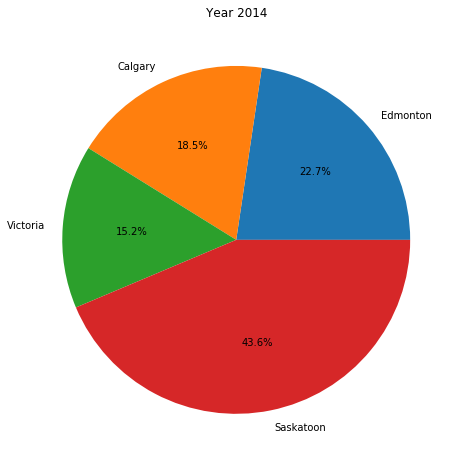

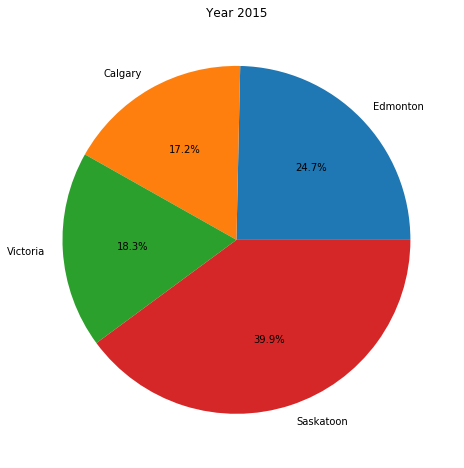

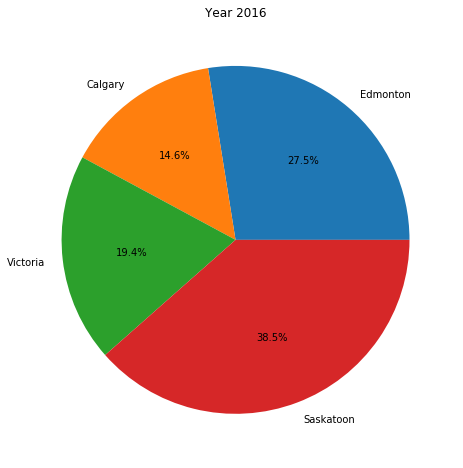

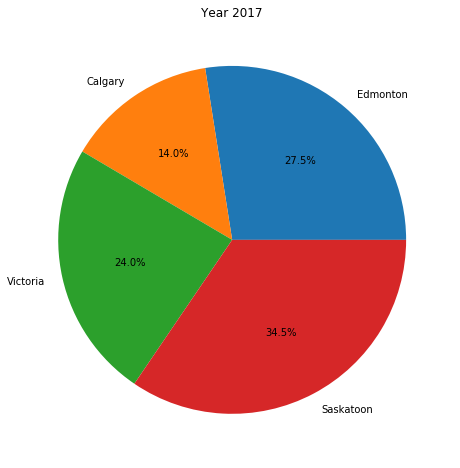

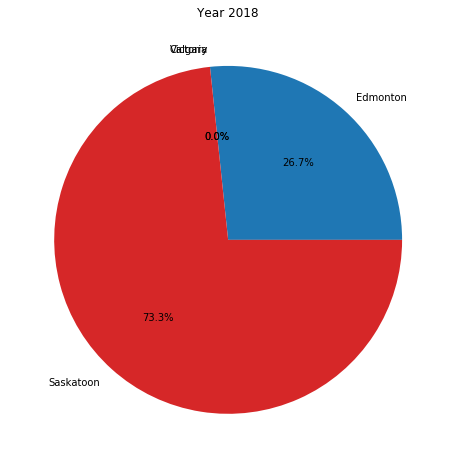

In [9]:
## let's store the "daily victory count" as a dictionary that maps pairs (year, city name) to counts.
viclist = co.defaultdict(int)
for x in coml:
    temps = [(dictL[i][x][ncl[0]], dictN[i]) for i in range(4)]
    temps = sorted(temps)
    viclist[(x.year, temps[0][1])] += 1

yearlist = sorted(set([k[0] for k,v in viclist.items()]))

yeartots = co.defaultdict(int)
for k,v in viclist.items():
    yeartots[k[0]] += v

pcts = co.defaultdict(float)
for y in yearlist:
    for c in dictN:
        pcts[(y,c)] = 100.0*viclist[(y,c)]/yeartots[y]

for y in yearlist:
    pc = [pcts[(y,c)] for c in dictN]
    plt.figure(figsize=(8,8))
    plt.title("Year "+str(y))
    plt.pie(pc, labels=dictN, autopct='%1.1f%%')
    plt.show()
    

**Exercise 4**: Repeat Exercise 3, but with summer weather.

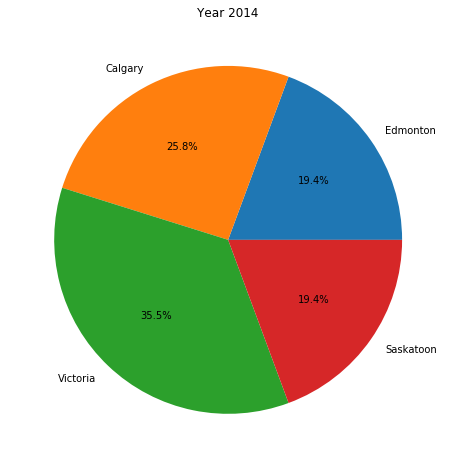

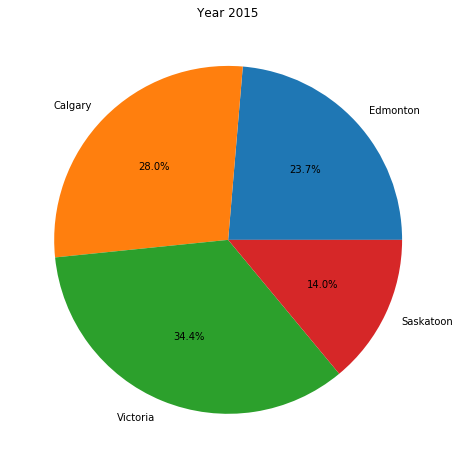

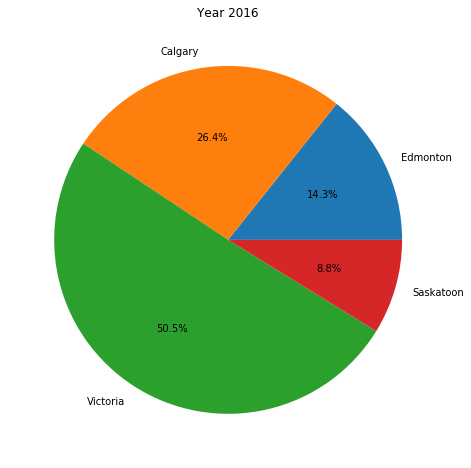

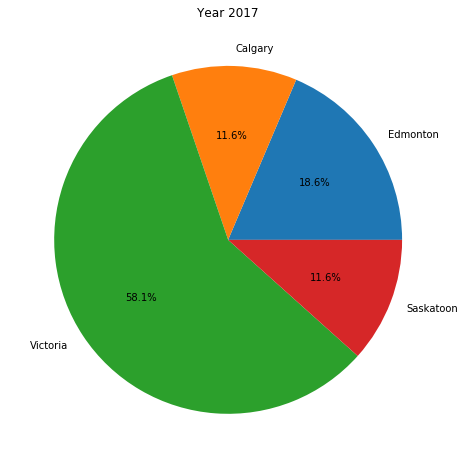

In [10]:
## We will use June 21st as the first day of summer -- the actual date depends on the year, but
## given that we are making pie charts, being one day inaccurate is of no real consequence.
## Similarly, we use September 23rd for fall's start.

## let's store the "daily victory count" as a dictionary that maps pairs (year, city name) to counts.
viclist = co.defaultdict(int)
for x in coml:
    summer_dt = dt.datetime(x.year, 5, 21)
    fall_dt = dt.datetime(x.year, 8, 23)
    if x>=summer_dt and x<fall_dt:
        temps = [(dictL[i][x][ncl[0]], dictN[i]) for i in range(4)]
        temps = sorted(temps)
        viclist[(x.year, temps[0][1])] += 1

yearlist = sorted(set([k[0] for k,v in viclist.items()]))

yeartots = co.defaultdict(int)
for k,v in viclist.items():
    yeartots[k[0]] += v

pcts = co.defaultdict(float)
for y in yearlist:
    for c in dictN:
        pcts[(y,c)] = 100.0*viclist[(y,c)]/yeartots[y]

for y in yearlist:
    pc = [pcts[(y,c)] for c in dictN]
    plt.figure(figsize=(8,8))
    plt.title("Year "+str(y))
    plt.pie(pc, labels=dictN, autopct='%1.1f%%')
    plt.show()

**Exercise 5:** Repeat Exercise 1, using the percentage of days where a city has the most precipitation (among all four cities).

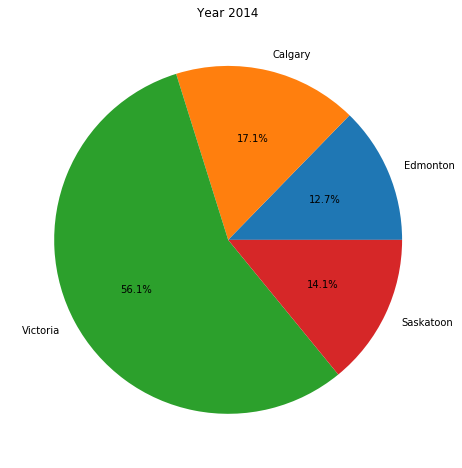

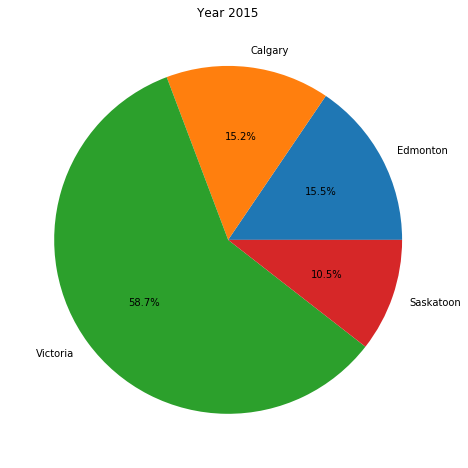

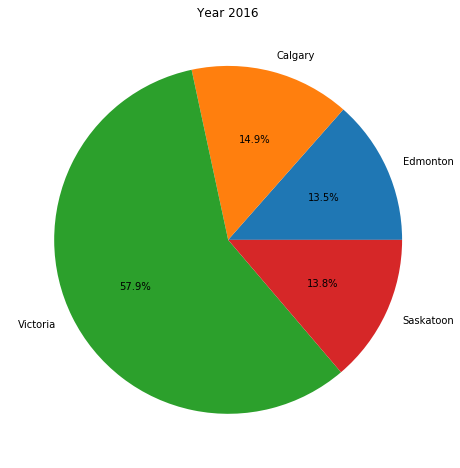

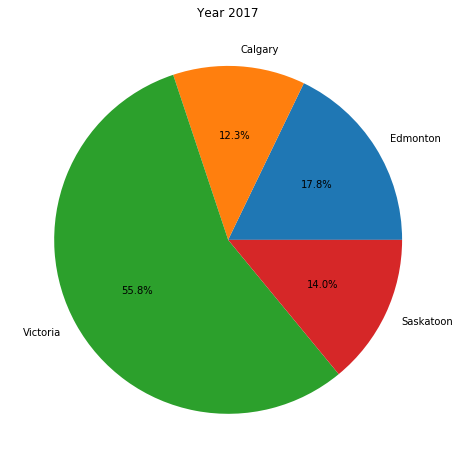

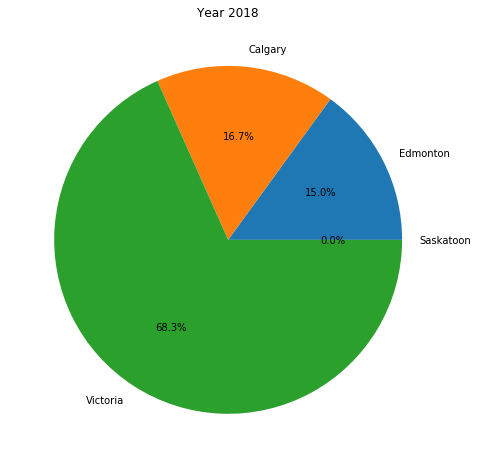

In [11]:
## let's store the "daily victory count" as a dictionary that maps pairs (year, city name) to counts.
viclist = co.defaultdict(int)
for x in coml:
    temps = [(dictL[i][x][ncl[5]], dictN[i]) for i in range(4)]
    temps = sorted(temps)
    viclist[(x.year, temps[-1][1])] += 1

yearlist = sorted(set([k[0] for k,v in viclist.items()]))

yeartots = co.defaultdict(int)
for k,v in viclist.items():
    yeartots[k[0]] += v

pcts = co.defaultdict(float)
for y in yearlist:
    for c in dictN:
        pcts[(y,c)] = 100.0*viclist[(y,c)]/yeartots[y]

for y in yearlist:
    pc = [pcts[(y,c)] for c in dictN]
    plt.figure(figsize=(8,8))
    plt.title("Year "+str(y))
    plt.pie(pc, labels=dictN, autopct='%1.1f%%')
    plt.show()

**Exercise 6:** Make a matplotlib plot where with two subplots.  The plot on the left will be from Exercise 2, and the plot on the right will be from Exercise 4.  i.e. the left pie chart will be the percentage of summer days with highest max temperature, the plot on the right will be the percentage of days with coldest max temperature.

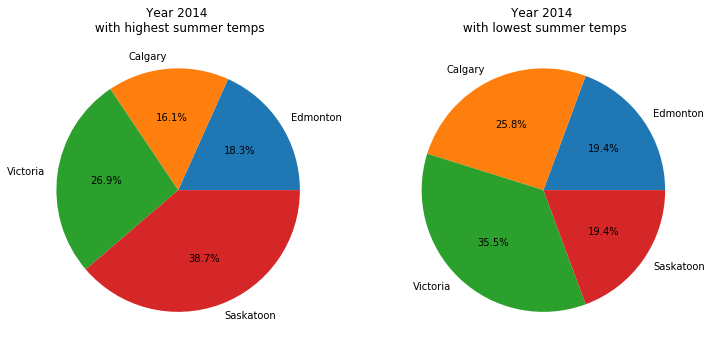

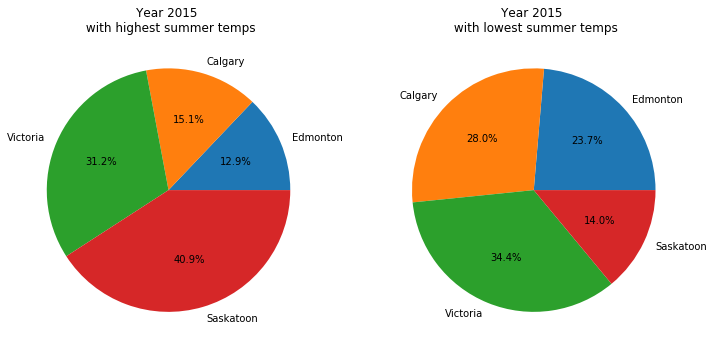

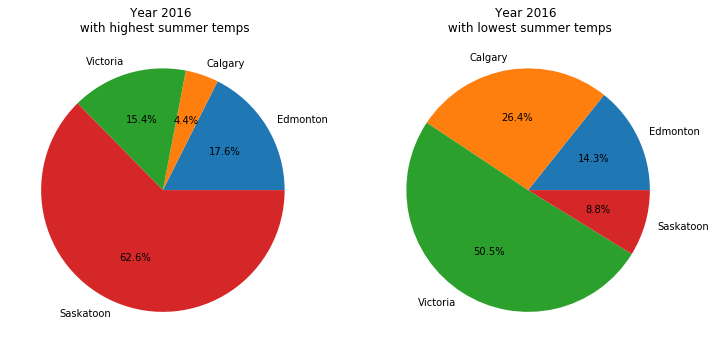

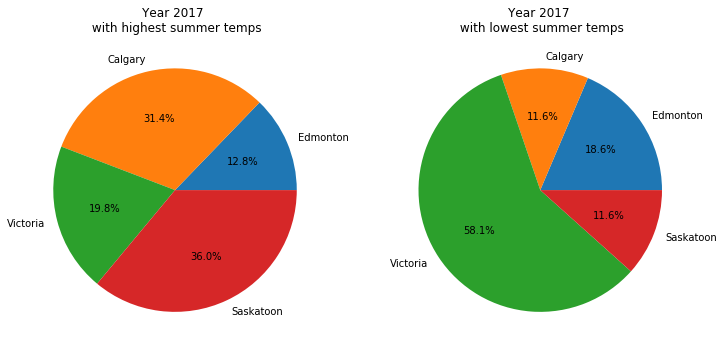

In [12]:
## let's store the "daily victory count" as a dictionary that maps pairs (year, city name) to counts.
viclist = co.defaultdict(int)
loslist = co.defaultdict(int)
for x in coml:
    summer_dt = dt.datetime(x.year, 5, 21)
    fall_dt = dt.datetime(x.year, 8, 23)
    if x>=summer_dt and x<fall_dt:
        temps = [(dictL[i][x][ncl[0]], dictN[i]) for i in range(4)]
        temps = sorted(temps)
        viclist[(x.year, temps[-1][1])] += 1
        loslist[(x.year, temps[0][1])] += 1
        
yearlist = sorted(set([k[0] for k,v in viclist.items()]))

yeartots = co.defaultdict(int)
for k,v in viclist.items():
    yeartots[k[0]] += v

pcts1 = co.defaultdict(float)
pcts2 = co.defaultdict(float)
for y in yearlist:
    for c in dictN:
        pcts1[(y,c)] = 100.0*viclist[(y,c)]/yeartots[y]
        pcts2[(y,c)] = 100.0*loslist[(y,c)]/yeartots[y]
        
for y in yearlist:
    pc1 = [pcts1[(y,c)] for c in dictN]
    pc2 = [pcts2[(y,c)] for c in dictN]
    plt.figure(figsize=(12,12))

    plt.subplot(1,2,1)
    plt.title("Year "+str(y)+" \n with highest summer temps")
    plt.pie(pc1, labels=dictN, autopct='%1.1f%%')
    
    plt.subplot(1,2,2)
    plt.title("Year "+str(y)+" \n with lowest summer temps")
    plt.pie(pc2, labels=dictN, autopct='%1.1f%%')
    
    plt.show()